# About tasty and healthy food
**Project Description:** TripAdvisor rating prediction of european restaurants.

**Goal:** To help to estimate rating.

**Objectives:** Create model to predict restaurant rating.

**Dataset Description:** Dataset consists of info of 40 000 restaurants into train set and 10 000 restaurants into test set.

Dataset features:
1. Restaurant_id — идентификационный номер ресторана / сети ресторанов;
2. City — город, в котором находится ресторан;
3. Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
4. Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
5. Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
6. Price Range — диапазон цен в ресторане;
7. Number of Reviews — количество отзывов о ресторане;
8. Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
9. URL_TA — URL страницы ресторана на TripAdvosor;
10. ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [1]:
import os
import math
from collections import Counter
from itertools import chain, combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.stats import ttest_ind

pd.options.display.max_columns = 40

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [3]:
# Set random seed
RANDOM_SEED = 42

In [4]:
# Save requirements
!pip freeze > requirements.txt

# Data preparing
## Collecting and formating

In [5]:
def format_price_range(val):
    """Convert dollar signs of Price_range feature to numbers"""
    val = val.replace('$$$$', '3')
    val = val.replace('$$ - $$$', '2')
    val = val.replace('$', '1')
    if val == '':
        return np.nan
    return float(val)


def format_id_ta(val):
    """Convert ID_TA feature to numbers"""
    return int(val[1:])


def collect_data(path):
    """Read train and test datasets and join them"""
    # Datasets reading
    df_train = pd.read_csv(path+'main_task.csv', converters={'Price Range': format_price_range, 'ID_TA': format_id_ta})
    df_test = pd.read_csv(path+'kaggle_task.csv', converters={'Price Range': format_price_range, 'ID_TA': format_id_ta})
    sample_submission = pd.read_csv(path+'sample_submission.csv')

    # Join train and test datasets
    df_train['sample'] = 1 # Train flag = 1
    df_test['sample'] = 0 # Train flag = 0
    df_test['Rating'] = 0 # Fill target variable of the test dataset with zeros
    df_join = df_train.append(df_test, sort=False).reset_index(drop=True) # Join
    
    return (df_train, df_test, df_join, sample_submission)


def format_dataset(df):
    """Format dataset"""
    # Rename columns
    df.rename(columns={
        'Cuisine Style': 'Cuisine',
        'Price Range': 'Price_range',
        'Number of Reviews': 'Reviews_num',
    }, inplace=True)

    # Split 'Cuisine' feature
    df['Cuisine'] = df['Cuisine'].str.strip('[]').str.replace("',\s'", '|').str.replace("'", '')

    # Split 'Reviews' feature
    df['Reviews'] = df['Reviews'].str.lower().replace('[[], []]', np.nan, regex=False)
    df[['Reviews', 'Rev_day1']] = df['Reviews'].str.strip('[]').str.split('],\s\[', expand=True)
    df[['Review1', 'Review2']] = df['Reviews'].str.strip("'\"").str.split("['\"],\s['\"]", expand=True)
    df['Review1'] = df['Review1'].str.replace('[().,!?@#$%^&*:;]', ' ').str.replace("['\"]", '')
    df['Review2'] = df['Review2'].str.replace('[().,!?@#$%^&*:;]', ' ').str.replace("['\"]", '')
    df.drop(['Reviews'], axis=1, inplace=True)
    df[['Rev_day1', 'Rev_day2']] = df['Rev_day1'].str.strip("'").str.split("',\s'", expand=True)
    df['Rev_day1'] = pd.to_datetime(df['Rev_day1'])
    df['Rev_day2'] = pd.to_datetime(df['Rev_day2'])
    df[['Rev_day1', 'Rev_day2']] =  df[['Rev_day1', 'Rev_day2']].max() - df[['Rev_day1', 'Rev_day2']]
    df['Rev_day1'] = df['Rev_day1'].dt.days
    df['Rev_day2'] = df['Rev_day2'].dt.days

    # Swap date and review columns if date1 < date2
    idx = (df['Rev_day1'] < df['Rev_day2'])
    df.loc[idx, ['Rev_day1', 'Rev_day2']] = df.loc[idx, ['Rev_day2', 'Rev_day1']].values
    df.loc[idx, ['Review1', 'Review2']] = df.loc[idx, ['Review2', 'Review1']].values


def check_features_format(df):
    """Check format of dataframe features"""
    # Features to check
    cols_regex = {
        'Restaurant_id': 'id_\d+',
    }

    # Check and print result
    for key, val in cols_regex.items():
        a = df[key].str.match(val).sum()
        b = df[key].count()
        print(f"'{key}' feature matches the regex format '{val}' for {a} of {b} rows")

## Feature engineering

In [6]:
def create_new_features(df):
    # Create feature of difference between two review dates
    df['Rev_day_delta'] = df['Rev_day1'] - df['Rev_day2']

    # Create feature of number of reviews on the site
    df['Site_rev_num'] = 0
    df['Site_rev_num'] += df['Rev_day1'].notna()
    df['Site_rev_num'] += df['Rev_day2'].notna()
    
    # Create feature of average site review length
    df['Site_rev_len'] = df['Review1'].str.count('\w+') + df['Review2'].str.count('\w+')
    idx = df['Site_rev_num'] > 0
    df.loc[idx, 'Site_rev_len'] /= df.loc[idx, 'Site_rev_num']
    df['Site_rev_len'].fillna(0, inplace=True)
    
    # Create feature of cuisine number
    df.loc[df['Cuisine'].notna(), 'Cuisine_num'] = df.loc[df['Cuisine'].notna(), 'Cuisine'].apply(lambda x: len(x.split('|')))
        
    # Create feature of country
    country = {
        'London': 'England',
        'Paris': 'France',
        'Madrid': 'Spain',
        'Barcelona': 'Spain',
        'Berlin': 'Germany',
        'Milan': 'Italy',
        'Rome': 'Italy',
        'Prague': 'Czech Republic',
        'Lisbon': 'Portugal',
        'Vienna': 'Austria',
        'Amsterdam': 'Netherlands',
        'Brussels': 'Belgium',
        'Hamburg': 'Germany',
        'Munich': 'Germany',
        'Lyon': 'France',
        'Stockholm': 'Sweden',
        'Budapest': 'Hungary',
        'Warsaw': 'Poland',
        'Dublin': 'Ireland',
        'Copenhagen': 'Denmark',
        'Athens': 'Greece',
        'Edinburgh': 'Scotland',
        'Zurich': 'Switzerland',
        'Oporto': 'Portugal',
        'Geneva': 'Switzerland',
        'Krakow': 'Poland',
        'Oslo': 'Norway',
        'Helsinki': 'Finland',
        'Bratislava': 'Slovakia',
        'Luxembourg': 'Luxembourg',
        'Ljubljana': 'Slovenia',
    }
    df['Country'] = df['City'].map(country)
    
    # Create feature of city population (in millions)
    population = {
        'London': 8.567, 
        'Paris': 9.904, 
        'Madrid': 5.567,
        'Barcelona': 4.920,
        'Berlin': 3.406,
        'Milan': 2.945,
        'Rome': 3.339,
        'Prague': 1.162,
        'Lisbon': 2.812,
        'Vienna': 2.400,
        'Amsterdam': 1.031,
        'Brussels': 1.743,
        'Hamburg': 1.757,
        'Munich': 1.275,
        'Lyon': 1.423,
        'Stockholm': 1.264,
        'Budapest': 1.679,
        'Warsaw': 1.707,
        'Dublin': 1.059,
        'Copenhagen': 1.085,
        'Athens': 3.242,
        'Edinburgh': 0.505,
        'Zurich': 1.108,
        'Oporto': 1.337,
        'Geneva': 1.240,
        'Krakow': 0.756,
        'Oslo': 0.835,
        'Helsinki': 1.115,
        'Bratislava': 0.424,
        'Luxembourg': 0.107,
        'Ljubljana': 0.315,
    }
    df['Population'] = df['City'].map(population)
    
    # Create feature of capital city
    is_capital = {
        'London': 1, 
        'Paris': 1, 
        'Madrid': 1,
        'Barcelona': 0,
        'Berlin': 1,
        'Milan': 0,
        'Rome': 1,
        'Prague': 1,
        'Lisbon': 1,
        'Vienna': 1,
        'Amsterdam': 1,
        'Brussels': 1,
        'Hamburg': 0,
        'Munich': 0,
        'Lyon': 0,
        'Stockholm': 1,
        'Budapest': 1,
        'Warsaw': 1,
        'Dublin': 1,
        'Copenhagen': 1,
        'Athens': 1,
        'Edinburgh': 0,
        'Zurich': 0,
        'Oporto': 0,
        'Geneva': 0,
        'Krakow': 0,
        'Oslo': 1,
        'Helsinki': 1,
        'Bratislava': 1,
        'Luxembourg': 1,
        'Ljubljana': 1,
    }
    df['Is_capital'] = df['City'].map(is_capital)

    # Create features of visitors per year (in millions)
    visiros_euromonitor = {
        'London': 19.233, 
        'Paris': 17.560, 
        'Madrid': 5.440,
        'Barcelona': 6.714,
        'Berlin': 5.959,
        'Milan': 6.481,
        'Rome': 10.065,
        'Prague': 8.948,
        'Lisbon': 3.539,
        'Vienna': 6.410,
        'Amsterdam': 8.354,
        'Brussels': 3.942,
        'Hamburg': 1.450,
        'Munich': 4.066,
        'Lyon': 3.3,
        'Stockholm': 2.604,
        'Budapest': 3.822,
        'Warsaw': 2.850,
        'Dublin': 5.213,
        'Copenhagen': 3.069,
        'Athens': 5.728,
        'Edinburgh': 1.660,
        'Zurich': 2.240,
        'Oporto': 2.341,
        'Geneva': 1.150,
        'Krakow': 2.732,
        'Oslo': 1,
        'Helsinki': 1,
        'Bratislava': 0.5,
        'Luxembourg': 0.5,
        'Ljubljana': 0.5,
    }
    visiros_mastercard = {
        'London': 19.880, 
        'Paris': 18.030, 
        'Madrid': 5.260,
        'Barcelona': 8.200,
        'Berlin': 4.940,
        'Milan': 7.650,
        'Rome': 7.120,
        'Prague': 5.810,
        'Lisbon': 3.630,
        'Vienna': 6.690,
        'Amsterdam': 8.000,
        'Brussels': 2.710,
        'Hamburg': 1.450,
        'Munich': 5.250,
        'Lyon': 3.3,
        'Stockholm': 2.080,
        'Budapest': 3.360,
        'Warsaw': 1.370,
        'Dublin': 4.970,
        'Copenhagen': 1.630,
        'Athens': 2.680,
        'Edinburgh': 1.660,
        'Zurich': 2.240,
        'Oporto': 2.341,
        'Geneva': 1.150,
        'Krakow': 2.732,
        'Oslo': 1,
        'Helsinki': 1,
        'Bratislava': 0.5,
        'Luxembourg': 0.5,
        'Ljubljana': 0.5,
    }
    df['Visit_euromt'] = df['City'].map(visiros_euromonitor)
    df['Visit_master'] = df['City'].map(visiros_mastercard)
    
    # Create feature of restaurants number in city
    restaurants_num = df[['City', 'Ranking']].groupby('City')['Ranking'].max()
    df['Restaurants_num'] = df['City'].map(restaurants_num)
    
    # Create feature of relative ranking by restaurants number
    df['Ranking_restr'] = df['Ranking'] / df['Restaurants_num']
    
    # Create feature of relative ranking by reviews number
    df['Ranking_restr_review'] = df['Ranking_restr'] / df['Reviews_num']
    
    # Create feature of relative ranking by population
    df['Ranking_popul'] = df['Ranking'] / df['Population']
    
    # Create feature of relative ranking by visitors
    df['Ranking_vis_master'] = df['Ranking'] / df['Visit_master']
    df['Ranking_vis_euromt'] = df['Ranking'] / df['Visit_euromt']
    
    # Create feature of relative ranking by restaurants number and population
    df['Ranking_restr_popul'] = df['Ranking_restr'] / df['Population']
    
    # Create feature of relative ranking by restaurants number and visitors
    df['Ranking_restr_vis_master'] = df['Ranking_restr'] / df['Visit_master']
    df['Ranking_restr_vis_euromt'] = df['Ranking_restr'] / df['Visit_euromt']

    # Create feature of citizens per restaurant
    df['Population_restr'] = df['Population'] / df['Restaurants_num']
    
    # Create feature of visitors per restaurant
    df['Vis_master_restr'] = df['Visit_master'] / df['Restaurants_num']
    df['Vis_euromt_restr'] = df['Visit_euromt'] / df['Restaurants_num']
    
    # Create feature of reviews per citizens per restaurant
    df['Reviews_popul_restr'] = df['Reviews_num'] / df['Population_restr']
    
    # Create feature of reviews per visitors per restaurant
    df['Reviews_vis_master_restr'] = df['Reviews_num'] / df['Vis_master_restr']
    df['Reviews_vis_euromt_restr'] = df['Reviews_num'] / df['Vis_euromt_restr']
    
    # Create boolean features for NaN's
    df['Cuisine_NaN'] = df['Cuisine'].isna().astype('uint8')
    df['Price_range_NaN'] = df['Price_range'].isna().astype('uint8')
    df['Reviews_num_NaN'] = df['Reviews_num'].isna().astype('uint8')
    df['Rev_day1_NaN'] = df['Rev_day1'].isna().astype('uint8')
    df['Rev_day2_NaN'] = df['Rev_day2'].isna().astype('uint8')

## Deleting of useless features

In [7]:
def delete_useless_features(df):
    df.drop(['Restaurant_id', 'Review1', 'Review2', 'URL_TA'], axis=1, inplace=True)

## Dirty data (wrong values) handling

In [ ]:
def dirty_handling(df):
    """Replace wrong values to NaN for features with finit set of posible values"""
    # Fill the dict with possible column values
    possible_vals = {}

    for column, vals in possible_vals.items():
        # Add NaN to list
        vals = list(vals)
        vals.append(np.nan)

        # Replace values
        mask = df[column].isin(vals)
        df[column].where(mask, inplace=True)

        # Show the result
        replaced_num = df[column].shape[0] - mask.sum()
        if replaced_num:
            print(f"{str(replaced_num).rjust(6)} cells have been replaced with NaN in column '{column}'")

## Receiving of general information

In [8]:
df_train, df_test, df_join, sample_submission = collect_data('/kaggle/input/sf-dst-restaurant-rating/')

format_dataset(df_train)
format_dataset(df_test)
format_dataset(df_join)

check_features_format(df_join)

create_new_features(df_train)
create_new_features(df_test)
create_new_features(df_join)

delete_useless_features(df_train)
delete_useless_features(df_test)
delete_useless_features(df_join)

dirty_handling(df_train)
dirty_handling(df_test)
dirty_handling(df_join)

'Restaurant_id' feature matches the regex format 'id_\d+' for 50000 of 50000 rows


**Show general information of datasets**

In [9]:
df_train.head()

,City,Cuisine,Ranking,Rating,Price_range,Reviews_num,ID_TA,sample,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len,Cuisine_num,Country,Population,Is_capital,Visit_euromt,Visit_master,Restaurants_num,Ranking_restr,Ranking_restr_review,Ranking_popul,Ranking_vis_master,Ranking_vis_euromt,Ranking_restr_popul,Ranking_restr_vis_master,Ranking_restr_vis_euromt,Population_restr,Vis_master_restr,Vis_euromt_restr,Reviews_popul_restr,Reviews_vis_master_restr,Reviews_vis_euromt_restr,Cuisine_NaN,Price_range_NaN,Reviews_num_NaN,Rev_day1_NaN,Rev_day2_NaN
0,Paris,European|French|International,5570.0,3.5,2.0,194.0,1912643,1,98.0,57.0,41.0,2,4.5,3.0,France,9.904,1,17.560,18.03,13986.0,0.398255,0.002053,562.399031,308.929562,317.198178,0.040212,0.022088,0.022680,0.000708,0.001289,0.001256,2.739584e+05,150487.188020,154515.034169,0,0,0,0,0
1,Stockholm,NaN,1537.0,4.0,NaN,10.0,7992032,1,617.0,235.0,382.0,2,2.5,NaN,Sweden,1.264,1,2.604,2.08,2464.0,0.623782,0.062378,1215.981013,738.942308,590.245776,0.493499,0.299895,0.239548,0.000513,0.000844,0.001057,1.949367e+04,11846.153846,9462.365591,1,1,0,0,0
2,London,Japanese|Sushi|Asian|Grill|Vegetarian Friendly...,353.0,4.5,3.0,688.0,8632781,1,51.0,49.0,2.0,2,3.0,7.0,England,8.567,1,19.233,19.88,16444.0,0.021467,0.000031,41.204622,17.756539,18.353871,0.002506,0.001080,0.001116,0.000521,0.001209,0.001170,1.320587e+06,569088.128773,588232.309052,0,0,0,0,0
3,Berlin,NaN,3458.0,5.0,NaN,3.0,1358776,1,NaN,NaN,NaN,0,0.0,NaN,Germany,3.406,1,5.959,4.94,6372.0,0.542687,0.180896,1015.267176,700.000000,580.298708,0.159333,0.109856,0.091070,0.000535,0.000775,0.000935,5.612449e+03,3869.635628,3207.920792,1,1,0,1,1
4,Munich,German|Central European|Vegetarian Friendly,621.0,4.0,2.0,84.0,6864963,1,372.0,100.0,272.0,2,7.0,3.0,Germany,1.275,0,4.066,5.25,2763.0,0.224756,0.002676,487.058824,118.285714,152.729956,0.176279,0.042811,0.055277,0.000461,0.001900,0.001472,1.820329e+05,44208.000000,57081.160846,0,0,0,0,0


In [10]:
df_test.head()

,City,Cuisine,Ranking,Price_range,Reviews_num,ID_TA,sample,Rating,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len,Cuisine_num,Country,Population,Is_capital,Visit_euromt,Visit_master,Restaurants_num,Ranking_restr,Ranking_restr_review,Ranking_popul,Ranking_vis_master,Ranking_vis_euromt,Ranking_restr_popul,Ranking_restr_vis_master,Ranking_restr_vis_euromt,Population_restr,Vis_master_restr,Vis_euromt_restr,Reviews_popul_restr,Reviews_vis_master_restr,Reviews_vis_euromt_restr,Cuisine_NaN,Price_range_NaN,Reviews_num_NaN,Rev_day1_NaN,Rev_day2_NaN
0,Paris,Bar|Pub,12963.0,2.0,4.0,10746918,0,0,NaN,NaN,NaN,0,0.0,2.0,France,9.904,1,17.560,18.03,13976.0,0.927519,0.231880,1308.865105,718.968386,738.211845,0.093651,0.051443,0.052820,0.000709,0.001290,0.001256,5644.588045,3100.610094,3183.599089,0,0,0,1,1
1,Helsinki,European|Scandinavian|Gluten Free Options|Vege...,106.0,2.0,97.0,6674944,0,0,119.0,83.0,36.0,2,3.5,5.0,Finland,1.115,1,1.000,1.00,1137.0,0.093228,0.000961,95.067265,106.000000,106.000000,0.083612,0.093228,0.093228,0.000981,0.000880,0.000880,98913.901345,110289.000000,110289.000000,0,0,0,0,0
2,Edinburgh,Vegetarian Friendly,810.0,2.0,28.0,13129638,0,0,81.0,60.0,21.0,2,3.0,1.0,Scotland,0.505,0,1.660,1.66,1765.0,0.458924,0.016390,1603.960396,487.951807,487.951807,0.908759,0.276460,0.276460,0.000286,0.000941,0.000941,97861.386139,29771.084337,29771.084337,0,0,0,0,0
3,London,Italian|Mediterranean|European|Vegetarian Frie...,1669.0,3.0,202.0,680417,0,0,95.0,82.0,13.0,2,2.5,5.0,England,8.567,1,19.233,19.88,16443.0,0.101502,0.000502,194.817322,83.953722,86.777934,0.011848,0.005106,0.005278,0.000521,0.001209,0.001170,387707.015291,167076.760563,172697.239120,0,0,0,0,0
4,Bratislava,Italian|Mediterranean|European|Seafood|Vegetar...,37.0,3.0,162.0,1112354,0,0,32.0,18.0,14.0,2,4.5,6.0,Slovakia,0.424,1,0.500,0.50,881.0,0.041998,0.000259,87.264151,74.000000,74.000000,0.099051,0.083995,0.083995,0.000481,0.000568,0.000568,336608.490566,285444.000000,285444.000000,0,0,0,0,0


In [11]:
df_join.head()

,City,Cuisine,Ranking,Rating,Price_range,Reviews_num,ID_TA,sample,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len,Cuisine_num,Country,Population,Is_capital,Visit_euromt,Visit_master,Restaurants_num,Ranking_restr,Ranking_restr_review,Ranking_popul,Ranking_vis_master,Ranking_vis_euromt,Ranking_restr_popul,Ranking_restr_vis_master,Ranking_restr_vis_euromt,Population_restr,Vis_master_restr,Vis_euromt_restr,Reviews_popul_restr,Reviews_vis_master_restr,Reviews_vis_euromt_restr,Cuisine_NaN,Price_range_NaN,Reviews_num_NaN,Rev_day1_NaN,Rev_day2_NaN
0,Paris,European|French|International,5570.0,3.5,2.0,194.0,1912643,1,98.0,57.0,41.0,2,4.5,3.0,France,9.904,1,17.560,18.03,13986.0,0.398255,0.002053,562.399031,308.929562,317.198178,0.040212,0.022088,0.022680,0.000708,0.001289,0.001256,2.739584e+05,150487.188020,154515.034169,0,0,0,0,0
1,Stockholm,NaN,1537.0,4.0,NaN,10.0,7992032,1,617.0,235.0,382.0,2,2.5,NaN,Sweden,1.264,1,2.604,2.08,2464.0,0.623782,0.062378,1215.981013,738.942308,590.245776,0.493499,0.299895,0.239548,0.000513,0.000844,0.001057,1.949367e+04,11846.153846,9462.365591,1,1,0,0,0
2,London,Japanese|Sushi|Asian|Grill|Vegetarian Friendly...,353.0,4.5,3.0,688.0,8632781,1,51.0,49.0,2.0,2,3.0,7.0,England,8.567,1,19.233,19.88,16444.0,0.021467,0.000031,41.204622,17.756539,18.353871,0.002506,0.001080,0.001116,0.000521,0.001209,0.001170,1.320587e+06,569088.128773,588232.309052,0,0,0,0,0
3,Berlin,NaN,3458.0,5.0,NaN,3.0,1358776,1,NaN,NaN,NaN,0,0.0,NaN,Germany,3.406,1,5.959,4.94,6372.0,0.542687,0.180896,1015.267176,700.000000,580.298708,0.159333,0.109856,0.091070,0.000535,0.000775,0.000935,5.612449e+03,3869.635628,3207.920792,1,1,0,1,1
4,Munich,German|Central European|Vegetarian Friendly,621.0,4.0,2.0,84.0,6864963,1,372.0,100.0,272.0,2,7.0,3.0,Germany,1.275,0,4.066,5.25,2763.0,0.224756,0.002676,487.058824,118.285714,152.729956,0.176279,0.042811,0.055277,0.000461,0.001900,0.001472,1.820329e+05,44208.000000,57081.160846,0,0,0,0,0


In [12]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [13]:
df_train.info()
print()
df_test.info()
print()
df_join.info()
print()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   City                      40000 non-null  object 
 1   Cuisine                   30717 non-null  object 
 2   Ranking                   40000 non-null  float64
 3   Rating                    40000 non-null  float64
 4   Price_range               26114 non-null  float64
 5   Reviews_num               37457 non-null  float64
 6   ID_TA                     40000 non-null  int64  
 7   sample                    40000 non-null  int64  
 8   Rev_day1                  33529 non-null  float64
 9   Rev_day2                  28973 non-null  float64
 10  Rev_day_delta             28973 non-null  float64
 11  Site_rev_num              40000 non-null  int64  
 12  Site_rev_len              40000 non-null  float64
 13  Cuisine_num               30717 non-null  float64
 14  Countr

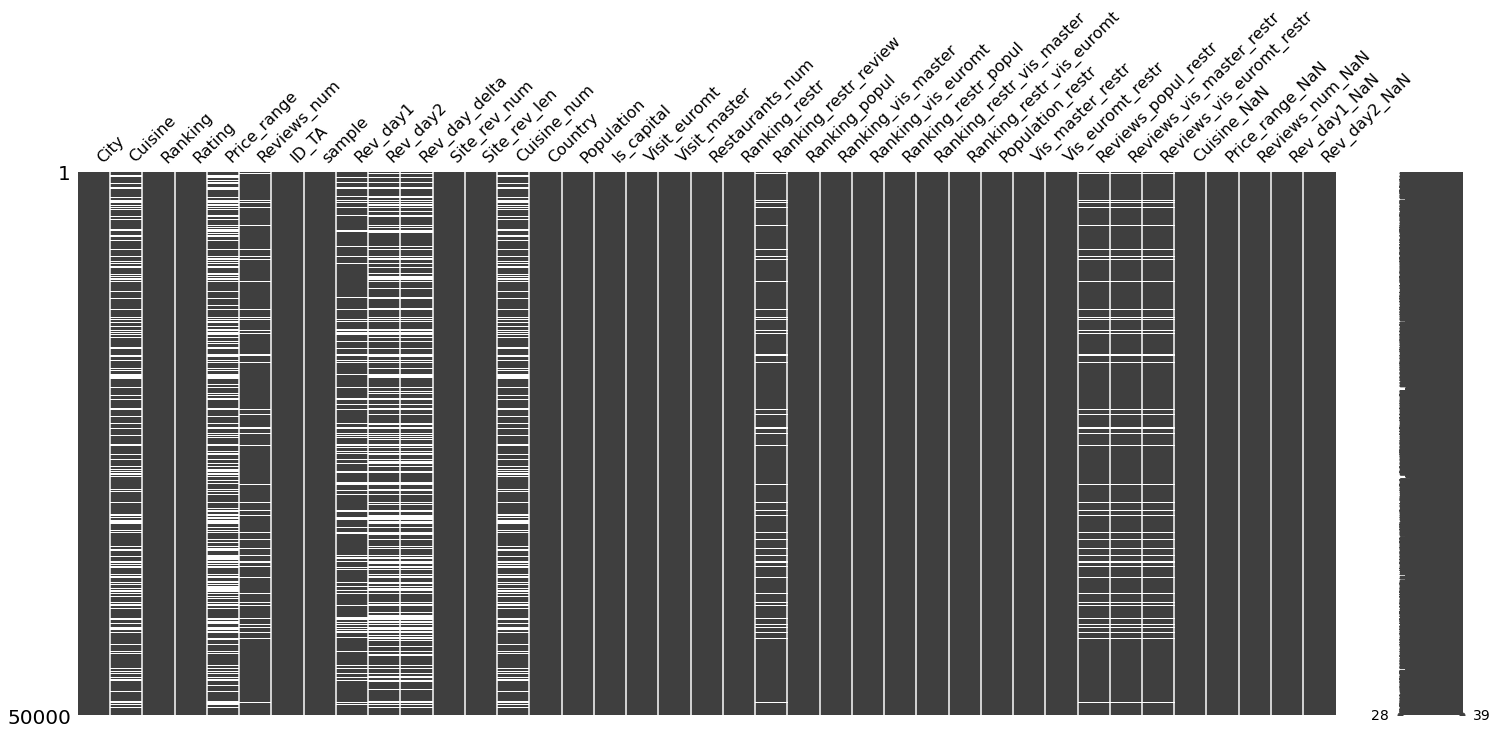

In [14]:
msno.matrix(df_join);

**Declare target variable, quantity, ordinal and categorical features**

In [15]:
# Declare target variable
target = ['Rating']

# Declare categorical features
categorical_cols = [
    'City',
    'Country',
    'Cuisine',
]

# Declare quantity features
quantity_cols = [
    'Cuisine_num',
    'ID_TA',
    'Price_range',
    'Reviews_num',
    'Rev_day1',
    'Rev_day2',
    'Rev_day_delta',
    'Site_rev_num',
    'Site_rev_len',
    
    'Population',
    'Population_restr',
    'Ranking_popul',
    'Ranking_restr',
    'Ranking_restr_popul',
    'Ranking_restr_review',
    'Ranking_restr_vis_euromt',
    'Ranking_restr_vis_master',
    'Ranking_vis_master',
    'Ranking_vis_euromt',
    'Restaurants_num',
    'Reviews_popul_restr',
    'Reviews_vis_master_restr',
    'Reviews_vis_euromt_restr',
    'Visit_euromt',
    'Visit_master',
    'Vis_euromt_restr',
    'Vis_master_restr',
]

# Declare ordinal features
ordinal_cols = [
    'Cuisine_NaN',
    'Is_capital',
    'Price_range_NaN',
    'Reviews_num_NaN',
    'Rev_day1_NaN',
    'Rev_day2_NaN',
]

# Declare categorized quantity features
quantity_categ_cols = [
    'Ranking',
]

# Update quantity, ordinal and categorical feature lists
categorical_cols = [col for col in df_join.columns if col in categorical_cols]
quantity_cols = [col for col in df_join.columns if col in quantity_cols]
ordinal_cols = [col for col in df_join.columns if col in ordinal_cols]
quantity_categ_cols = [col for col in df_join.columns if col in quantity_categ_cols]

**View unique values**

In [16]:
# Show number of qnique values of categorical features
categorical_unique = {}
for column in categorical_cols:
    categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df_join.loc[df_join[column].notna(), column].str.split('|')))).sort_values(ascending=False)
    print((column + ':').ljust(16), end='')
    print(str(len(categorical_unique[column])).rjust(6))

City:               31
Cuisine:           125
Country:            23


In [17]:
# Show qnique values of categorical features
pd.set_option('display.max_rows', None)

for column in categorical_cols:
    print(column + ':')
    print(categorical_unique[column]) # in frequency order
    # print(categorical_unique[column].sort_index()) # in alphabet order
    print()
    
pd.reset_option('display.max_rows')

City:
London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
dtype: int64

Cuisine:
Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
Gluten Free Options     5185
Bar                     4094
French                  3970
Asian                   3786
Pizza                   3502
Spanish                 3456
Pub                     3058
Cafe                    2883
Fast 

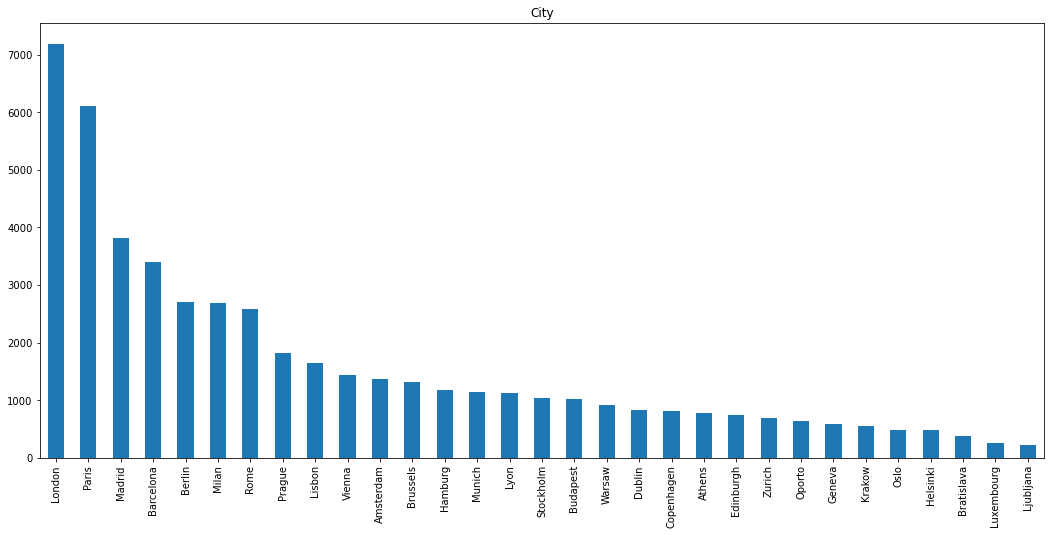

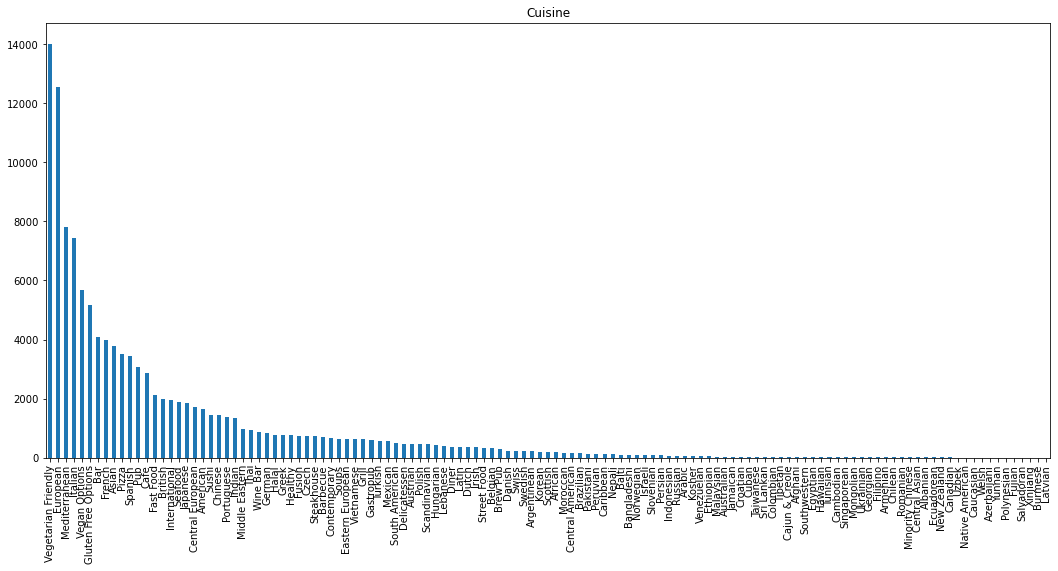

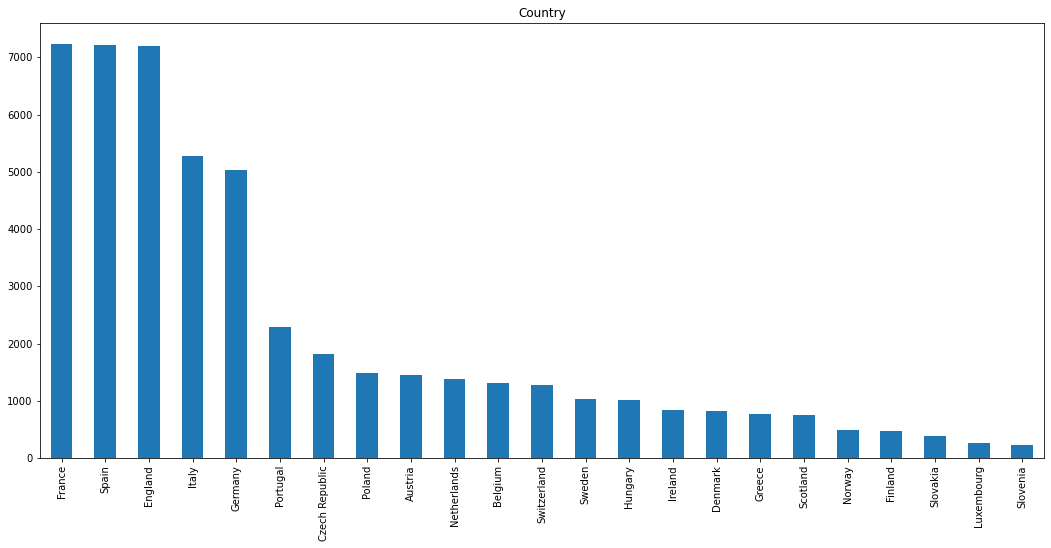

In [18]:
# Show distribution of categorical features
for column in categorical_cols:
    categorical_unique[column].plot.bar(figsize=(18, 8), title=column)
    plt.show()

    
# matplotlib realization:

# Create figure with [rows] graphs
# rows = len(categorical_cols)
# fig, axs = plt.subplots(rows, figsize=(18, rows*8))

# Plot graphs
# for i, column in enumerate(categorical_cols):
#     axs[i].bar(categorical_unique[column].index, categorical_unique[column].values)
#     axs[i].set_title(column)
#     axs[i].xaxis.set_tick_params(rotation=90)

In [19]:
# Show number of qnique values of quantity and ordinal features
for column in df_join.columns:
    if df_join[column].dtype != 'O':
        print(column.join(['', ':']).ljust(16), end='')
        print(str(df_join[column].nunique()).rjust(6))

Ranking:         12975
Rating:             10
Price_range:         3
Reviews_num:      1573
ID_TA:           49963
sample:              2
Rev_day1:         2278
Rev_day2:         1575
Rev_day_delta:    1310
Site_rev_num:        3
Site_rev_len:       21
Cuisine_num:        14
Population:         31
Is_capital:          2
Visit_euromt:       28
Visit_master:       28
Restaurants_num:    31
Ranking_restr:   49728
Ranking_restr_review: 46615
Ranking_popul:   49681
Ranking_vis_master: 48080
Ranking_vis_euromt: 49038
Ranking_restr_popul: 49997
Ranking_restr_vis_master: 49990
Ranking_restr_vis_euromt: 49992
Population_restr:    31
Vis_master_restr:    31
Vis_euromt_restr:    31
Reviews_popul_restr:  9822
Reviews_vis_master_restr:  9822
Reviews_vis_euromt_restr:  9822
Cuisine_NaN:         2
Price_range_NaN:     2
Reviews_num_NaN:     2
Rev_day1_NaN:        2
Rev_day2_NaN:        2


In [23]:
# Show qnique values of quantity and ordinal features
columns = ['Rating', 'Price_range', 'Site_rev_num', 'Site_rev_len', 'Cuisine_num', 'Is_capital',
           'Cuisine_NaN', 'Price_range_NaN', 'Reviews_num_NaN', 'Rev_day1_NaN', 'Rev_day2_NaN',]

for column in df_join.columns:
    if df_join[column].dtype != 'O' and column in columns:
        print(column.join(['', ':']).ljust(16), end='')
        print(np.sort(df_join[column].unique()))

Rating:         [0.  1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Price_range:    [ 1.  2.  3. nan]
Site_rev_num:   [0 1 2]
Site_rev_len:   [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10. ]
Cuisine_num:    [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13. 15. 21. nan]
Is_capital:     [0 1]
Cuisine_NaN:    [0 1]
Price_range_NaN:[0 1]
Reviews_num_NaN:[0 1]
Rev_day1_NaN:   [0 1]
Rev_day2_NaN:   [0 1]


## Visualization

In [32]:
def show_boxplots(df):
    """Show boxplots of quantity and ordinal features and check them for outliers existance"""
    # Join quantity columns with target variable
    columns = sorted(quantity_cols + target)

    # Create figure with [rows x cols] graphs
    cols = 5
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].boxplot(df.loc[df[column].notna(), column], showmeans=True)
        axs[idx].set_title(column)
        
        
def show_histograms(df):
    """Show distributions of quantity and ordinal features"""
    # Fill the list of bins' step if know it
    bin_step = {
        'Cuisine_num': 1,
        'Price_range': 0.5,
        'Rating': 0.5,
        'Site_rev_num': 1,
        'Site_rev_len': 0.5,
    }
    
    # Join quantity columns, ordinal columns and target variable
    columns = sorted(quantity_cols + ordinal_cols + target)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil(len(columns)/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        # Calculate indices of subplots
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)

        # Calculate number of bins and ranges
        if column in bin_step.keys():
            col_max = df[column].max()
            col_min = df[column].min()
            step = bin_step[column]
            offset = step / 2
            bins = int((col_max-col_min) / step) + 1
            range_ = (col_min - offset, col_max + offset)
        elif column in ordinal_cols:
            col_max = df[column].max()
            col_min = df[column].min()
            bins = int((col_max-col_min) * 2) + 1
            range_ = (col_min - 0.25, col_max + 0.25)
        else:
            bins = 20
            range_ = None

        # Plot
        axs[idx].hist(df.loc[df[column].notna(), column], bins, range_)
        axs[idx].set_title(column)
        
        
def show_CQF_boxplots(df):
    """Show boxplots of categorized quantity features"""
    NUM_OF_VALS = 10
    CATEGORY = 'City'

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    for i, column in enumerate(quantity_categ_cols):
        # Find masks
        categ_mask = {}
        top_categ_values = {}
        for column in quantity_categ_cols:
            # Find top NUM_OF_VALS values categorical feature
            top_categ_values[column] = categorical_unique[CATEGORY].index[:NUM_OF_VALS]

            # Find boolean masks
            categ_mask[column] = {}
            for value in top_categ_values[column]:
                categ_mask[column][value] = df[CATEGORY].str.contains(value)

        # Plot graphs
        if rows == 1:
            axs.boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_categ_values[column], rotation=5)
        else:
            axs[i].boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_categ_values[column], rotation=5)
            
    return (top_categ_values, categ_mask)
            
            
def show_CQF_histograms(df, top_categ_values, categ_mask):
    """Show distributions of categorized quantity features"""
    BINS = 100

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    for i, column in enumerate(quantity_categ_cols):
        # Plot graphs
        if rows == 1:
            for value in top_categ_values[column]:
                axs.hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs.set_title(column)
        else:
            for value in top_categ_values[column]:
                axs[i].hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs[i].set_title(column)

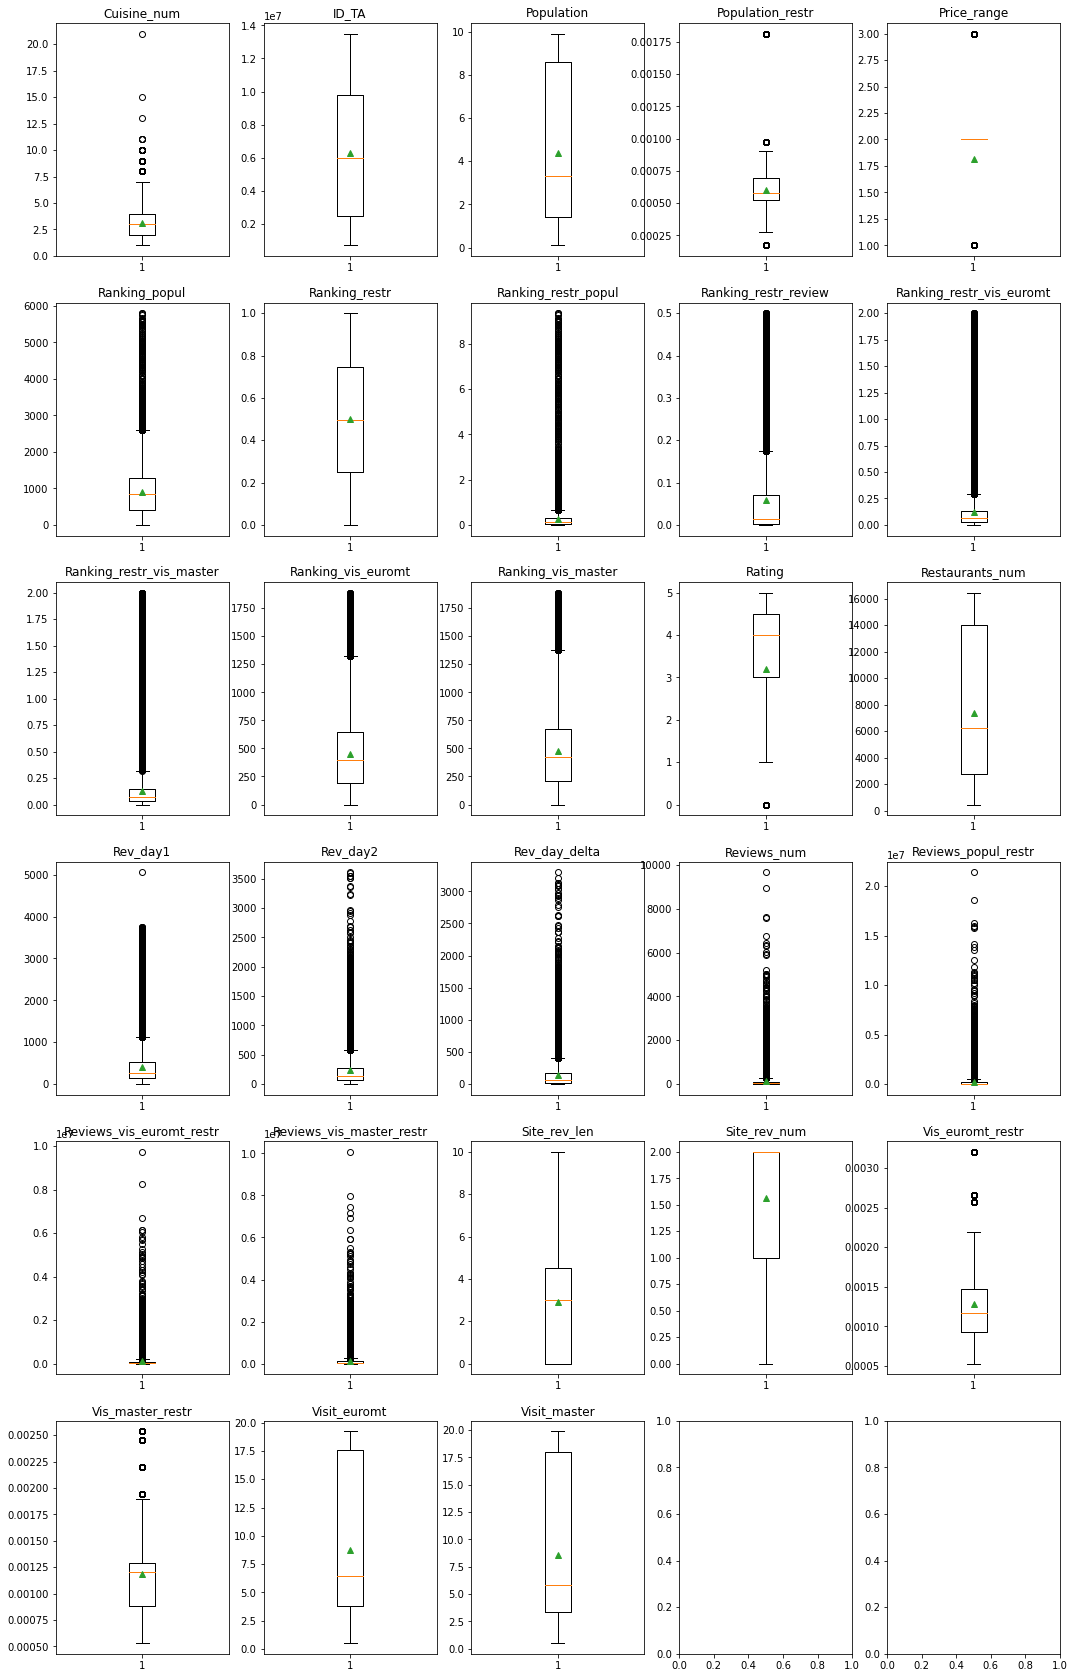

In [26]:
show_boxplots(df_join)

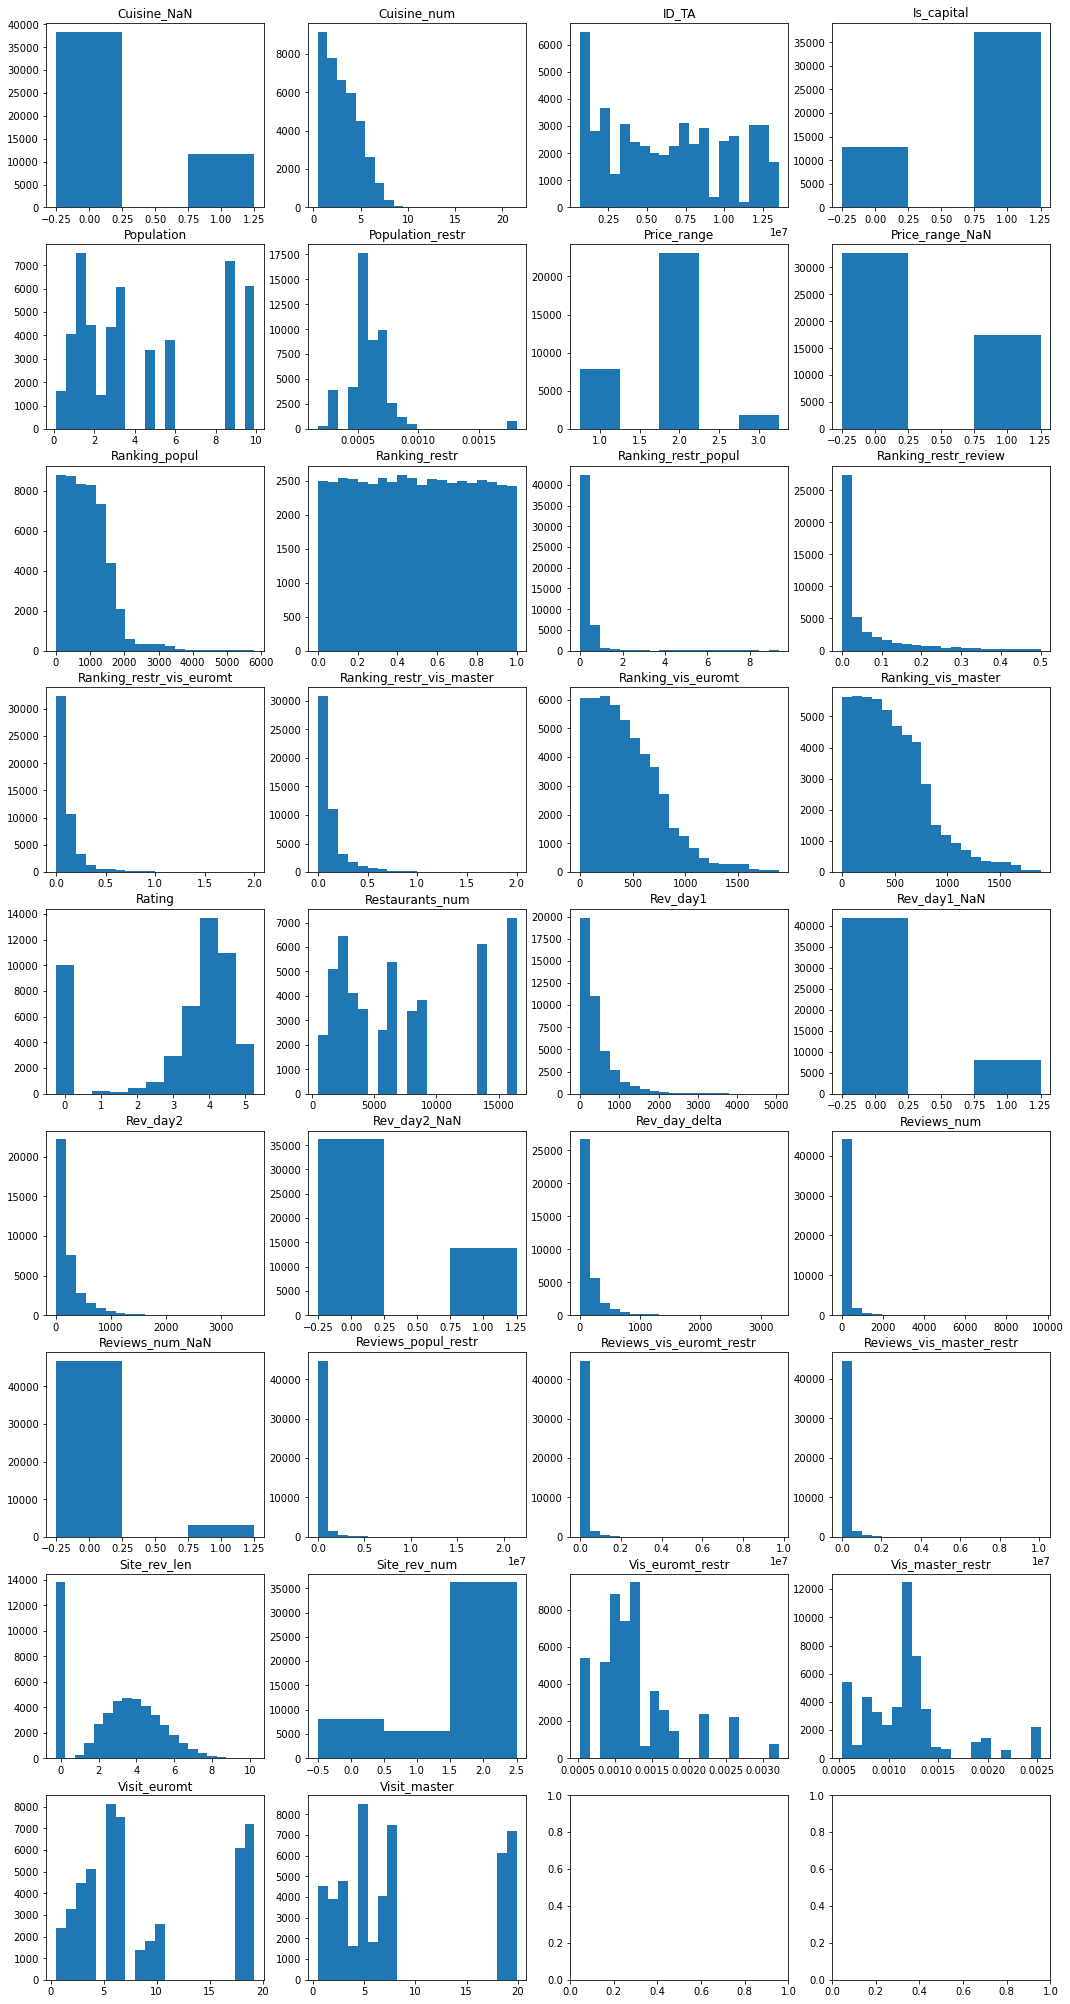

In [30]:
show_histograms(df_join)

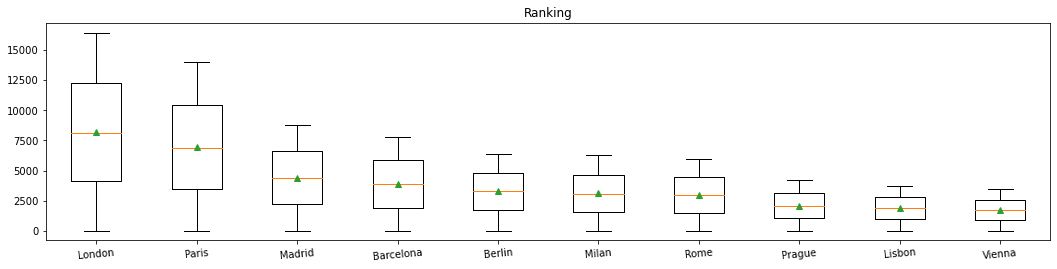

In [33]:
top_categ_values, categ_mask = show_CQF_boxplots(df_join)

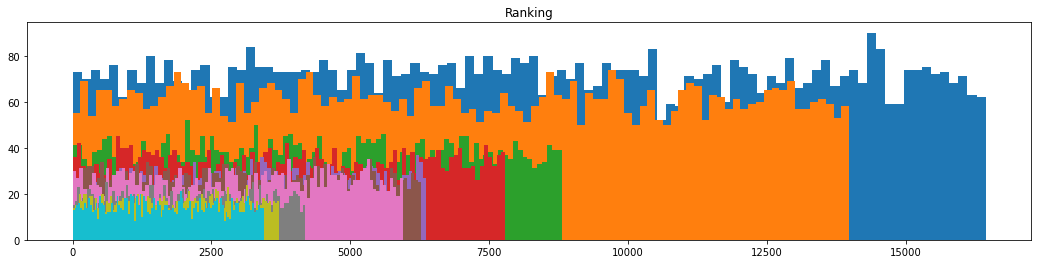

In [34]:
show_CQF_histograms(df_join, top_categ_values, categ_mask)

## Outliers handling

In [ ]:
def delete_outliers(df):
    """Show number of outliers and delete rows with outliers"""
    idx_dict = {}
    for column in columns:
        # Calculate NaNs, Q1, Q3, IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate indices of rows
        idx_dict[column] = list(df.loc[(~df[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)) & (df[column].notna()), column].index)

        # Show the result
        outliers_num = len(idx_dict[column])
        if outliers_num:
            print(f"{str(outliers_num).rjust(6)} outliers are in column '{column}'")
            
    # Exclude some columns from the process
    #cols = []
    cols = ['Price_range']
    for col in df.columns:
        if col in cols:
            columns.remove(col)

    # Union indices
    idx = set()
    for column in columns:
        idx.update(idx_dict[column])

    # Drop rows with outliers
    df.drop(idx, inplace=True)
    print(f"{len(idx)} rows have been dropped")

In [ ]:
# Don't delete outliers for RandomRegressionForest model
# delete_outliers(df_train)
# delete_outliers(df_test)
# delete_outliers(df_join)

## Correlation analysis
**Calculate and view correlation matrix**

In [35]:
# Calculate correlation matrix
corr_table = df_train.corr()
corr_table

,Ranking,Rating,Price_range,Reviews_num,ID_TA,sample,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len,Cuisine_num,Population,Is_capital,Visit_euromt,Visit_master,Restaurants_num,Ranking_restr,Ranking_restr_review,Ranking_popul,Ranking_vis_master,Ranking_vis_euromt,Ranking_restr_popul,Ranking_restr_vis_master,Ranking_restr_vis_euromt,Population_restr,Vis_master_restr,Vis_euromt_restr,Reviews_popul_restr,Reviews_vis_master_restr,Reviews_vis_euromt_restr,Cuisine_NaN,Price_range_NaN,Reviews_num_NaN,Rev_day1_NaN,Rev_day2_NaN
Ranking,1.000000,-0.368371,-0.103883,-0.222670,0.048826,NaN,0.208647,0.196224,0.137332,-0.139815,-0.124389,-0.332574,0.681709,0.224047,0.663411,0.676267,0.709194,0.572154,0.296796,0.416962,0.410331,0.487065,-0.180921,-0.217437,-0.192704,-0.060054,-0.056513,-0.181722,-0.214141,-0.221009,-0.211393,0.147995,0.233043,0.094078,0.106386,0.148478
Rating,-0.368371,1.000000,-0.022529,0.030964,0.159111,NaN,-0.125213,-0.107185,-0.101216,0.020550,0.008526,0.143386,-0.059917,0.015475,-0.023016,-0.038701,-0.061097,-0.544573,-0.143953,-0.447117,-0.485282,-0.505235,-0.147408,-0.200783,-0.201404,0.027775,0.065386,0.100632,0.031432,0.024956,0.020327,-0.038263,-0.064567,0.008386,-0.024727,-0.014332
Price_range,-0.103883,-0.022529,1.000000,0.173649,-0.144948,NaN,-0.090399,-0.059183,-0.077217,0.059322,0.056996,0.156582,0.031824,0.009644,0.013005,0.020270,0.019042,-0.187884,-0.123503,-0.170822,-0.152052,-0.146431,-0.056291,-0.061942,-0.056445,0.006733,-0.014800,-0.035470,0.158427,0.169466,0.170807,NaN,NaN,-0.038718,-0.016629,-0.080842
Reviews_num,-0.222670,0.030964,0.173649,1.000000,-0.286309,NaN,-0.231495,-0.197759,-0.172266,0.191031,0.151511,0.354874,0.015599,0.000982,0.046792,0.036775,0.026110,-0.399464,-0.242584,-0.325957,-0.338686,-0.332531,-0.131937,-0.177955,-0.169301,-0.038469,0.041231,0.043611,0.941668,0.945494,0.927333,-0.195070,-0.254273,NaN,-0.146297,-0.201782
ID_TA,0.048826,0.159111,-0.144948,-0.286309,1.000000,NaN,-0.178160,-0.110551,-0.119862,-0.309054,-0.270090,-0.109342,-0.055629,-0.001403,-0.072279,-0.072394,-0.059072,0.168795,0.302536,0.130603,0.146395,0.132006,0.054443,0.076897,0.063910,0.034619,-0.019050,0.005713,-0.267163,-0.275731,-0.272113,0.283675,0.267774,0.178326,0.245607,0.319597
sample,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rev_day1,0.208647,-0.125213,-0.090399,-0.231495,-0.178160,NaN,1.000000,0.837577,0.730876,-0.213419,-0.125710,-0.396889,-0.009239,-0.034626,-0.051224,-0.049816,-0.033004,0.413499,0.336577,0.309715,0.389148,0.379181,0.120003,0.183703,0.172652,0.036624,-0.076168,-0.063694,-0.218378,-0.221250,-0.218359,0.182283,0.339577,0.097198,NaN,0.213419
Rev_day2,0.196224,-0.107185,-0.059183,-0.197759,-0.110551,NaN,0.837577,1.000000,0.239298,NaN,0.041500,-0.334028,-0.000829,-0.014971,-0.029930,-0.030208,-0.018343,0.375400,0.334931,0.290039,0.354934,0.339625,0.115887,0.169048,0.153785,0.031420,-0.053459,-0.038451,-0.186388,-0.189207,-0.186589,0.156741,0.302901,NaN,NaN,NaN
Rev_day_delta,0.137332,-0.101216,-0.077217,-0.172266,-0.119862,NaN,0.730876,0.239298,1.000000,NaN,0.025922,-0.290157,-0.015423,-0.037047,-0.050822,-0.048861,-0.035827,0.287486,0.228756,0.213223,0.284307,0.278637,0.090464,0.138765,0.132941,0.028311,-0.061064,-0.055950,-0.162926,-0.163575,-0.161113,0.152920,0.235417,NaN,NaN,NaN
Site_rev_num,-0.139815,0.020550,0.059322,0.191031,-0.309054,NaN,-0.213419,NaN,NaN,1.000000,0.771263,0.309419,0.043465,0.098828,0.126016,0.121394,0.074335,-0.372463,-0.486909,-0.263310,-0.392241,-0.391617,-0.061712,-0.125327,-0.121735,-0.029633,0.126086,0.117800,0.177240,0.184882,0.182994,-0.345486,-0.506989,-0.411012,-0.909515,-0.939501


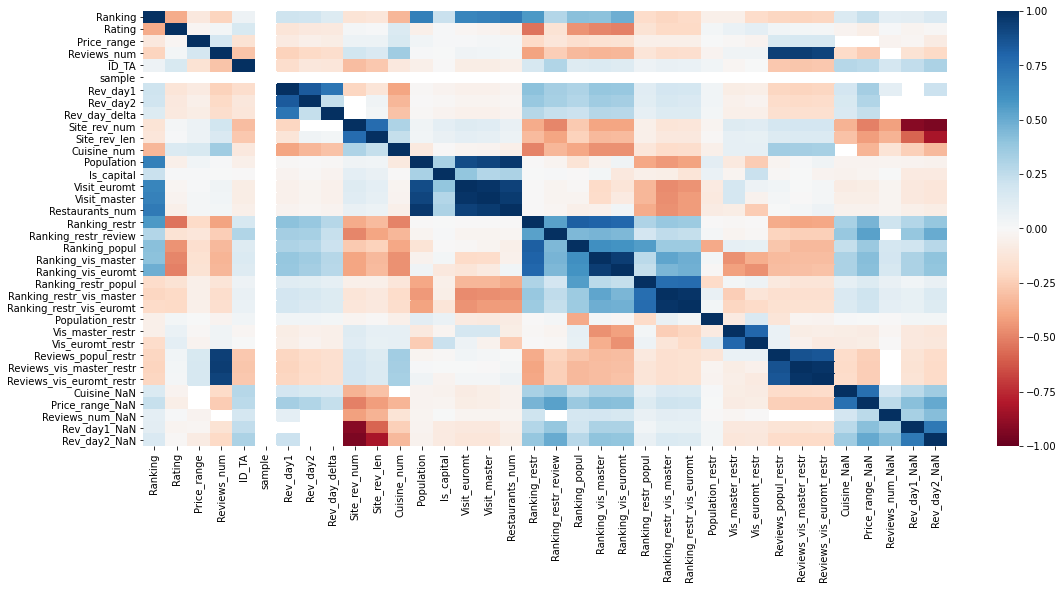

In [36]:
# Show correlation matrix
plt.subplots(figsize=(18, 8))
sns.heatmap(corr_table, vmin=-1, vmax=1, cmap="RdBu");

In [37]:
# Sort absolute correlation values with target variable
corr_table[target[0]].abs().sort_values(ascending=False)

Rating                      1.000000
Ranking_restr               0.544573
Ranking_vis_euromt          0.505235
Ranking_vis_master          0.485282
Ranking_popul               0.447117
Ranking                     0.368371
Ranking_restr_vis_euromt    0.201404
Ranking_restr_vis_master    0.200783
ID_TA                       0.159111
Ranking_restr_popul         0.147408
Ranking_restr_review        0.143953
Cuisine_num                 0.143386
Rev_day1                    0.125213
Rev_day2                    0.107185
Rev_day_delta               0.101216
Vis_euromt_restr            0.100632
Vis_master_restr            0.065386
Price_range_NaN             0.064567
Restaurants_num             0.061097
Population                  0.059917
Visit_master                0.038701
Cuisine_NaN                 0.038263
Reviews_popul_restr         0.031432
Reviews_num                 0.030964
Population_restr            0.027775
Reviews_vis_master_restr    0.024956
Rev_day1_NaN                0.024727
V

**Delete proportional and highly correlated features, and also features with week correlation with target variable**

In [38]:
# Define features to delete
cols = []

# Deleting
df_train.drop(columns=[col for col in df_train.columns if col in cols], inplace=True)
df_test.drop(columns=[col for col in df_test.columns if col in cols], inplace=True)
df_join.drop(columns=[col for col in df_join.columns if col in cols], inplace=True)

# Update quantity and ordinal feature lists
quantity_cols = [col for col in df_join.columns if col in quantity_cols and col not in cols]
ordinal_cols = [col for col in df_join.columns if col in ordinal_cols and col not in cols]
quantity_categ_cols = [col for col in df_join.columns if col in quantity_categ_cols and col not in cols]

## Significance analysis of categorical features
**Hypothesis testing**

С помощью теста Стьюдента проверим есть ли статистически значимая разница в распределении целевой переменной для разных значений категориальных признаков. Проверяем нулевую гипотезу о том, что распределения целевой переменной по различным значениям категориальных переменных неразличимы.

In [46]:
def hypothesis_testing(df):
    """Hypothesis testing of significance analysis"""
    NUM_OF_VALS = 10

    # Find not significant features
    mask = {}
    top_values = {}
    not_signif_columns = []
    for column in categorical_cols:
        # Find top NUM_OF_VALS values
        top_values[column] = categorical_unique[column].index[:NUM_OF_VALS]

        # Find boolean masks
        mask[column] = {}
        for value in top_values[column]:
            mask[column][value] = (df[column].str.contains('(?:^|\|)'+value+'(?:$|\|)')) & (df[target[0]].notna())

        # Student t-test for value combinations
        combs = list(combinations(top_values[column], 2))
        for comb in combs:
            if ttest_ind(df.loc[mask[column][comb[0]], target[0]], 
                         df.loc[mask[column][comb[1]], target[0]]) \
                            .pvalue <= 0.05/len(combs): # Bonferroni correction
                break
        else:
            not_signif_columns.append(column)

    # Show result
    print('Statistically significant differences have NOT been found for columns:')
    for column in not_signif_columns:
        print(f"'{column}'")
        
    return (top_values, mask)

In [47]:
top_values, mask = hypothesis_testing(df_train)

Statistically significant differences have NOT been found for columns:


**Delete features without statistically significant difference**

In [42]:
# Define features to delete
cols = []

# Deleting
df_train.drop(columns=[col for col in df_train.columns if col in cols], inplace=True)
df_test.drop(columns=[col for col in df_test.columns if col in cols], inplace=True)
df_join.drop(columns=[col for col in df_join.columns if col in cols], inplace=True)

# Update categorical feature list
categorical_cols = [col for col in df_join.columns if col in categorical_cols and col not in cols]

**View boxplots of significant features**

In [48]:
def boxplot_significants(df, top_values, mask):
    """Show boxplots of significant features"""
    # Create figure with [rows x cols] graphs
    rows = len(categorical_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(categorical_cols):
        if rows == 1:
            axs.boxplot([df.loc[mask[column][value], target[0]] for value in top_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_values[column], rotation=5)
            axs.set_ylabel(target[0])
        else:
            axs[i].boxplot([df.loc[mask[column][value], target[0]] for value in top_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_values[column], rotation=5)
            axs[i].set_ylabel(target[0])

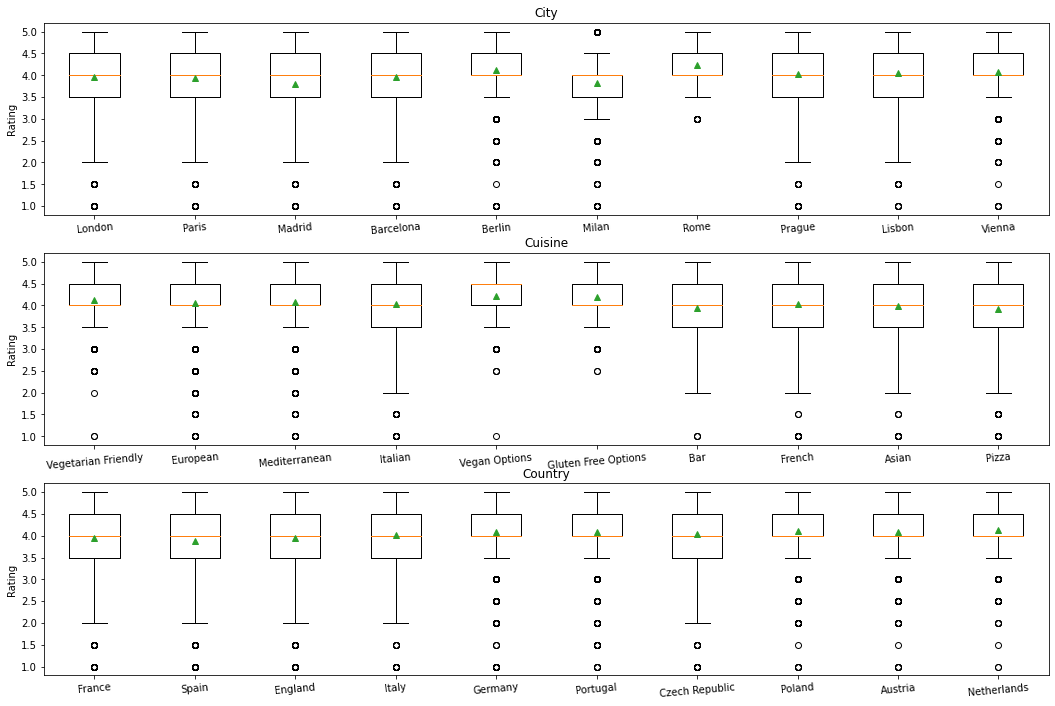

In [49]:
boxplot_significants(df_train, top_values, mask)

## Missing values handling

In [50]:
def fill_missing_values(df):
    # Fill missing values of quantity and ordinal features

    # Drop rows with missing values of target variable
    print(f"{df[target[0]].isna().sum()} rows have been dropped of missed target")
    df.dropna(subset=[target[0]], inplace=True)

    # Use a function to calc values to replace NaNs
    func = ['mean'] # Use list-like value to speed up calc

    # Calculate values
    replace_vals = df.agg(func)

    for column in quantity_cols + ordinal_cols:
        # Show the result
        print(f"{str(df[column].isna().sum()).rjust(6)} NaN have been replaced in column '{column}'")

        # Replace missing values
        if column == 'Price_range':
            df[column].fillna(2, inplace=True)
        elif column == 'Reviews_num':
            df[column].fillna(0, inplace=True)
#             values = df.groupby('City')['Reviews_num'].mean().round()
#             df['zzz'] = df['City'].map(values)
#             idx = df['Reviews_num'].isna()
#             df.loc[idx, 'Reviews_num'] = df.loc[idx, 'zzz']
#             df.drop('zzz', axis=1, inplace=True)
        else:
            df[column].fillna(0, inplace=True)
#             df[column].fillna(replace_vals[column][0], inplace=True)
        
        
    # Fill missing values of categorical features
    
    for column in categorical_cols:
        # Show the result
        print(f"{str(df[column].isna().sum()).rjust(6)} NaN have been replaced in column '{column}'")
        
        # Find value for replasing
        values_num = round(df.loc[df[column].notna(), column].apply(lambda x: len(x.split('|'))).mean())
        value = '|'.join(categorical_unique[column].index[:values_num])

        # Replace missing values
        df[column].fillna(value, inplace=True)

**Fill missing values**

In [51]:
fill_missing_values(df_train)
print()
fill_missing_values(df_test)
print()
fill_missing_values(df_join)

0 rows have been dropped of missed target
 13886 NaN have been replaced in column 'Price_range'
  2543 NaN have been replaced in column 'Reviews_num'
     0 NaN have been replaced in column 'ID_TA'
  6471 NaN have been replaced in column 'Rev_day1'
 11027 NaN have been replaced in column 'Rev_day2'
 11027 NaN have been replaced in column 'Rev_day_delta'
     0 NaN have been replaced in column 'Site_rev_num'
     0 NaN have been replaced in column 'Site_rev_len'
  9283 NaN have been replaced in column 'Cuisine_num'
     0 NaN have been replaced in column 'Population'
     0 NaN have been replaced in column 'Visit_euromt'
     0 NaN have been replaced in column 'Visit_master'
     0 NaN have been replaced in column 'Restaurants_num'
     0 NaN have been replaced in column 'Ranking_restr'
  2543 NaN have been replaced in column 'Ranking_restr_review'
     0 NaN have been replaced in column 'Ranking_popul'
     0 NaN have been replaced in column 'Ranking_vis_master'
     0 NaN have been re

## Dummies generation

In [78]:
def generate_dummies(df):
    """Dummies generation from categorical features"""
    # Generate dummies
    df_out = df
    for column in categorical_cols:
        df_out = pd.concat([df_out, df[column].str.get_dummies()], axis=1)

    # Drop categorical columns
    df_out.drop(categorical_cols, axis=1, inplace=True)
    
    return df_out

**Generate dummies**

In [79]:
df_train = generate_dummies(df_train)
df_test = generate_dummies(df_test)
df_join = generate_dummies(df_join)

# Learn model
## Prepare data

In [ ]:
# Prepare data for model
df_train, df_test, data, sample_submission = collect_data('/kaggle/input/sf-dst-restaurant-rating/')
format_dataset(data)
create_new_features(data)
delete_useless_features(data)
fill_missing_values(data)
data = generate_dummies(data)

## Tune features

In [ ]:
# Tune features
data.drop(['Is_capital', 'Vis_master_restr', 'Vis_euromt_restr', 'Ranking_restr_review',
           'Reviews_vis_master_restr', 'Reviews_vis_euromt_restr'], axis=1, inplace=True)

## Split data: features & target

In [ ]:
# Split data: Х - features, у - target variable
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data['Rating'].values
X = train_data.drop(['Rating'], axis=1)

## Split data: train & test

In [ ]:
# Split data on train and test parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Check data dimensions
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

## Create and learn model

In [ ]:
# Create model
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Learn model on the train set
model.fit(X_train, y_train)

**View model characteristics**

In [ ]:
# View important model characteristics
plt.rcParams['figure.figsize'] = (18, 8)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

## Test model

**Predict target**

In [ ]:
# Predict target variable on the train set
y_pred = model.predict(X_test)

**Data postprocessing**

In [ ]:
# Round to 0.5
y_pred = (y_pred*2).round() / 2

**View metrics**

In [ ]:
# Show metric: Mean Absolute Error (MAE)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

# Submission
**Learn model on 100% of train data**

In [ ]:
# Create model
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Learn model on the whole train set
model.fit(X, y)

# Predict target variable on the test set
predict_submission = model.predict(test_data.drop(['Rating'], axis=1))

# Round to 0.5
predict_submission = (predict_submission*2).round() / 2

**Write result to submission file**

In [ ]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission

## What's next?
Или, что делать, чтобы улучшить результат:

- Обработать оставшиеся признаки в понятный для машины формат
- Посмотреть, что еще можно извлечь из признаков
- Сгенерировать новые признаки
- Подгрузить дополнительные данные, например: по населению или благосостоянию городов
- Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!